#  _**PROJECT : Text Emotion Classification using Machine Learning**_
_____________________________________________________________________________________



## Data Set Loading, Setup, Class Distribution Count & Visualization

In [1]:
import pandas as pd
df = pd.read_csv("train.txt", sep=";", header=None, names=["text", "emotion"])
df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
# Count of each emotion label
df['emotion'].value_counts()


emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

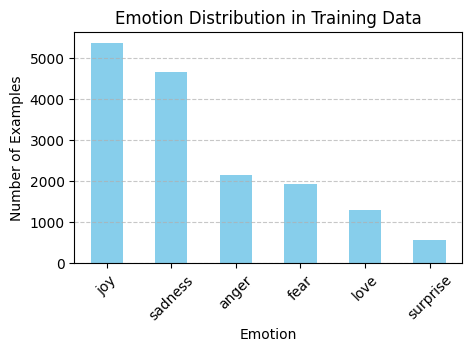

In [5]:
import matplotlib.pyplot as plt

# Count of each emotion
emotion_counts = df['emotion'].value_counts()

# Plotting bar chart
plt.figure(figsize=(5,3))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title("Emotion Distribution in Training Data")
plt.xlabel("Emotion")
plt.ylabel("Number of Examples")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The dataset contains 7 distinct emotions. Among them, joy and sadness are the most frequent, indicating a bias towards these two emotions. 
Emotions like surprise, love and fear are relatively rare, which may lead to class imbalance during model training. 
This imbalance is important to keep in mind, as it can affect how well the model performs on less frequent emotions.

## Text Preprocessing
### Cleaning the text

In [57]:
import re

# Define function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply the function to text column
df['clean_text'] = df['text'].apply(clean_text)

# Check original vs cleaned text
df[['text', 'clean_text']].head()


,text,clean_text
0,i didnt feel humiliated,i didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wrong,im grabbing a minute to post i feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy,i am feeling grouchy


Although the training data appears clean, we apply text cleaning to ensure consistency, handle future noisy inputs, and build a robust pipeline. This also makes our code reusable across various stages — training, validation, inference.


## Exploratory Data Analysis
### Word count Statistics and Visualizations (with insights)

In [58]:
# Add a new column: word count of each sentence
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# Show first few rows with length
df[['clean_text', 'word_count']].head()


,clean_text,word_count
0,i didnt feel humiliated,4
1,i can go from feeling so hopeless to so damned...,21
2,im grabbing a minute to post i feel greedy wrong,10
3,i am ever feeling nostalgic about the fireplac...,18
4,i am feeling grouchy,4


In [59]:
df['word_count'].describe()

count    16000.000000
mean        19.166313
std         10.986905
min          2.000000
25%         11.000000
50%         17.000000
75%         25.000000
max         66.000000
Name: word_count, dtype: float64

There are 16,000 training samples. The average sentence length is ~19 words, while the maximum is 66.  
Most sentences (75%) are within 25 words. Based on this, we plan to use a maximum input length of **40 words**, allowing us to cover most cases while excluding a few long outliers.


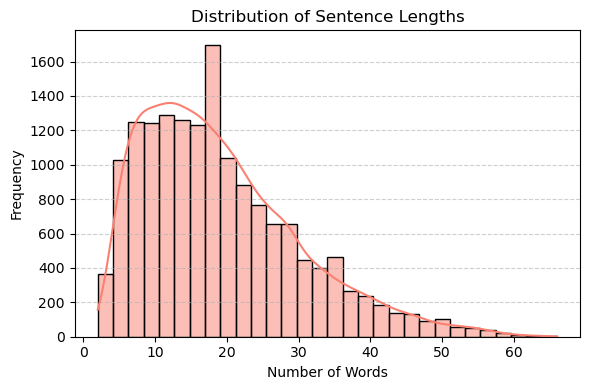

In [60]:
import seaborn as sns

# Plotting histogram
plt.figure(figsize=(6,4))
sns.histplot(df['word_count'], bins=30, kde=True, color='salmon')
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


*Sentence Length Distribution – Insights*

Most sentences are between **10 to 25 words** long.  
There is a noticeable **right skew** — meaning a few sentences are quite long (over 40 words), but rare.  
This indicates we might need to **set a max length** (like 40–50 words) during preprocessing to handle outliers.


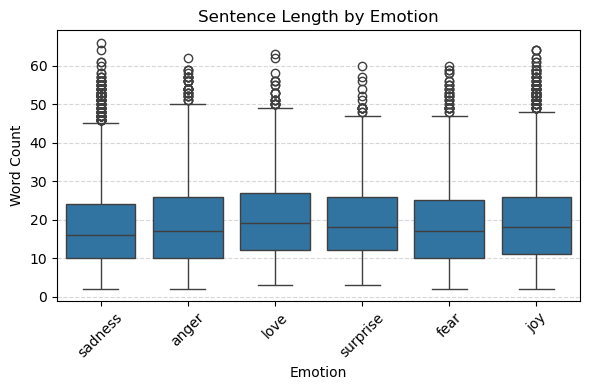

In [100]:
# Analysing sentence length (word count/ sentence) per emotion

plt.figure(figsize=(6,4))
sns.boxplot(x='emotion', y='word_count', data=df)
plt.title("Sentence Length by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Word Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Emotion-wise Sentence Length Patterns**

- The median sentence length across all emotions lies roughly between 15–20 words.
- `love` and `joy` emotions tend to have slightly **longer sentences** (higher medians).
- `anger`, `fear`, and `surprise` have slightly **shorter medians** — suggesting sharper, more concise expressions.
- All emotions have some **outliers** beyond 50 words, but very few — confirming the need for truncation beyond 40-50 tokens.
- The IQR (interquartile range) is fairly consistent, which means the sentence structure isn't too imbalanced among emotions.

## Label Encoding

In [71]:
# Label Encoding

from sklearn.preprocessing import LabelEncoder

# Initialize encoder
le = LabelEncoder()

# Fit & transform
df['label'] = le.fit_transform(df['emotion'])

# Check mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)


Label Mapping: {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}


In [63]:
# Feature and label separation
X = df['clean_text']        # Input text (already cleaned)
y = df['label']             # Encoded emotion labels

## Train Test Splitting

In [64]:
#Train test splitting

from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Text Vectorization
### TF-IDF

In [86]:
# Vectorization (Text to vectors)

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer with top 5000 words
tfidf = TfidfVectorizer(max_features=5000)

# Fit on training data and transform both training and test
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Optional: Check the shape of the transformed data
print("X_train vector shape:", X_train_vec.shape)
print("X_test vector shape:", X_test_vec.shape)


X_train vector shape: (12800, 5000)
X_test vector shape: (3200, 5000)


## Handling Class Imbalance
### Over sampling

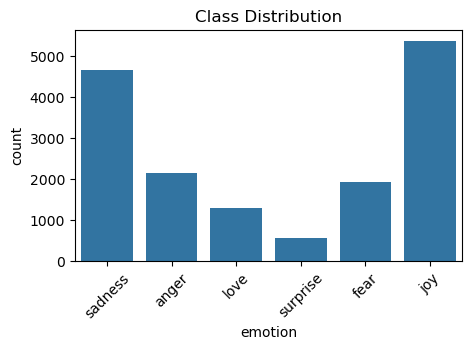

In [66]:
#checking imbalance and biasness
plt.figure(figsize=(5,3))
sns.countplot(x='emotion', data=df)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()


In [67]:
#Handling class imbalance

from imblearn.over_sampling import RandomOverSampler

# Initialize oversampler
ros = RandomOverSampler(random_state=42)

# Apply on TF-IDF vectors and labels
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vec, y_train)

# Check shape and new class distribution
print("Before Oversampling:", dict(pd.Series(y_train).value_counts()))
print("After Oversampling:", dict(pd.Series(y_train_resampled).value_counts()))


Before Oversampling: {2: 4341, 4: 3720, 0: 1732, 1: 1540, 3: 1008, 5: 459}
After Oversampling: {2: 4341, 4: 4341, 3: 4341, 0: 4341, 5: 4341, 1: 4341}


## Model Training & Evaluation on splitted test data
### Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the model
model = LogisticRegression(max_iter=1000)  # 1000 iterations for convergence

# Train on resampled balanced data
model.fit(X_train_resampled, y_train_resampled)

# Predict on original test set (not oversampled) - we haven't even done oversampling on testing data!
y_pred = model.predict(X_test_vec)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.885

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88       427
           1       0.84      0.85      0.85       397
           2       0.92      0.90      0.91      1021
           3       0.76      0.88      0.82       296
           4       0.94      0.90      0.92       946
           5       0.69      0.83      0.76       113

    accuracy                           0.89      3200
   macro avg       0.84      0.87      0.85      3200
weighted avg       0.89      0.89      0.89      3200



**Model Accuracy = 88.5% (Good)**

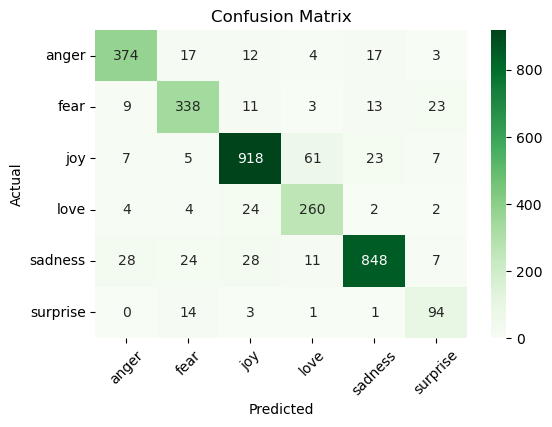

In [83]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it nicely
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()


**Confusion Matrix Insights** 

The model performed very well overall, especially for joy and sadness, where it made 918 and 848 correct predictions respectively — these are the highest among all.
Most emotions are predicted accurately, as seen by the dark green diagonal, which shows correct predictions.
However, there’s some confusion between:

_joy vs love → 61 joy texts predicted as love_
_sadness vs anger/fear/joy → some misclassifications here too_
_surprise is the most difficult for the model — it is often confused with fear (14 times)._

This indicates that while the model is strong on major emotions, it struggles with less frequent ones like surprise, which might benefit from more training data or targeted techniques.



## Testing on actual unseen Testing Data
### Performing  - Loading, Preprocessing, Vectorization, Label Encoding, etc. on Testing Data

In [84]:
# Load original test data
test_df = pd.read_csv("test.txt", sep=';', names=["text", "emotion"])

# Clean the text (same as before)
test_df["clean_text"] = test_df["text"].apply(clean_text)


In [88]:
# Transform using the SAME tfidf_vectorizer as before (DO NOT fit again)
X_final_test_vec = tfidf.transform(test_df["clean_text"])


In [89]:
# Encode target using same label encoder
y_final_test = le.transform(test_df["emotion"])


In [90]:
y_final_pred = model.predict(X_final_test_vec)

Accuracy on original test set: 0.8775

Classification Report:
               precision    recall  f1-score   support

       anger       0.84      0.89      0.86       275
        fear       0.85      0.84      0.85       224
         joy       0.93      0.88      0.91       695
        love       0.69      0.88      0.77       159
     sadness       0.95      0.88      0.92       581
    surprise       0.61      0.86      0.72        66

    accuracy                           0.88      2000
   macro avg       0.81      0.87      0.84      2000
weighted avg       0.89      0.88      0.88      2000



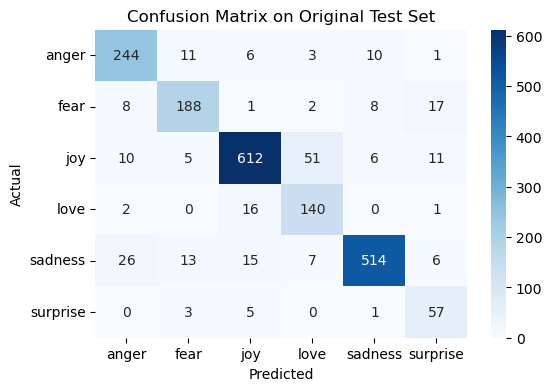

In [95]:
# Accuracy
print("Accuracy on original test set:", accuracy_score(y_final_test, y_final_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_final_test, y_final_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_final_test, y_final_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Original Test Set')
plt.show()


**_The model achieved a strong accuracy of 87.75%, indicating it can reliably predict emotions from unseen text._**

**Confusion Matrix Observations** - 

Most predictions fall on the diagonal, showing that the model is predicting the correct class in most cases.
Surprise and Love have the most confusion — frequently misclassified as joy, fear, or sadness.
High support classes (joy, sadness) are predicted very well, even under data imbalance.



## Actual Run-time testing

In [97]:
while True:
    user_input = input("Enter your sentence (or type 'exit' to stop): ")
    if user_input.lower() == 'exit':
        break

    # Clean input text
    cleaned_input = clean_text(user_input)

    # Vectorize using trained TF-IDF
    vec_input = tfidf.transform([cleaned_input])

    # Predict
    pred_label = model.predict(vec_input)[0]

    # Decode emotion
    emotion = le.inverse_transform([pred_label])[0]

    print(f"→ Predicted Emotion: {emotion}\n")


Enter your sentence (or type 'exit' to stop):  Wow! I scored 99% marks in chemistry


→ Predicted Emotion: joy



Enter your sentence (or type 'exit' to stop):  What the fuck! She is a liar.


→ Predicted Emotion: anger



Enter your sentence (or type 'exit' to stop):  I care about Alice very much.


→ Predicted Emotion: joy



Enter your sentence (or type 'exit' to stop):  I like Alice


→ Predicted Emotion: joy



Enter your sentence (or type 'exit' to stop):  I love Alice


→ Predicted Emotion: joy



Enter your sentence (or type 'exit' to stop):  My Grandpa has died today


→ Predicted Emotion: sadness



Enter your sentence (or type 'exit' to stop):  oh! That's a lion


→ Predicted Emotion: joy



Enter your sentence (or type 'exit' to stop):  O My god! Run away from here, that's a monster coming up


→ Predicted Emotion: anger



Enter your sentence (or type 'exit' to stop):  I can't imagine my life without you


→ Predicted Emotion: sadness



Enter your sentence (or type 'exit' to stop):  I think I'm falling for her


→ Predicted Emotion: sadness



Enter your sentence (or type 'exit' to stop):  That result came completely out of nowhere.


→ Predicted Emotion: sadness



Enter your sentence (or type 'exit' to stop):  ait, what? You did that without telling me?


→ Predicted Emotion: anger



Enter your sentence (or type 'exit' to stop):  What a plesant surprise!


→ Predicted Emotion: sadness



Enter your sentence (or type 'exit' to stop):  exit


## **🧠 Insights:**

✅ High accuracy on strong emotions like joy, sadness, anger.

⚠️ Confusion in subtle emotions like:

love → mistaken for joy or sadness
surprise → often missed (due to less training samples)

💡 TF-IDF + Logistic Regression are good baseline, but struggle with:

Subtle emotional tone
Multi-emotion blend (like sadness + love)

# Saving the Final Model

In [98]:
import joblib

joblib.dump(model, 'model.pkl')              # ML model
joblib.dump(tfidf, 'tfidf.pkl')              # TF-IDF vectorizer
joblib.dump(le, 'label_encoder.pkl')         # LabelEncoder for emotion names


['label_encoder.pkl']